In [1]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\mgphy\Anaconda3\envs\genai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
# images[0].save("fantasy_landscape.png")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\mgphy\Anaconda3\envs\genai\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mgphy\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|████

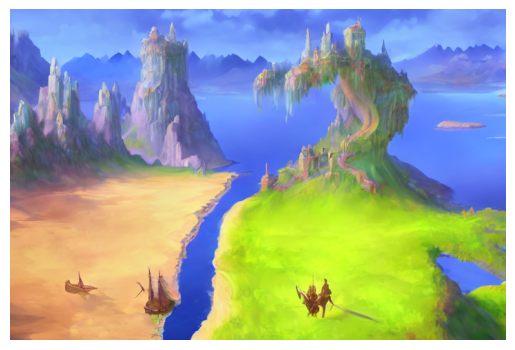

In [4]:
import matplotlib.pyplot as plt

# Assuming you have a list of images called 'images'
for image in images:
    plt.imshow(image)
    plt.axis('off')
    plt.show()

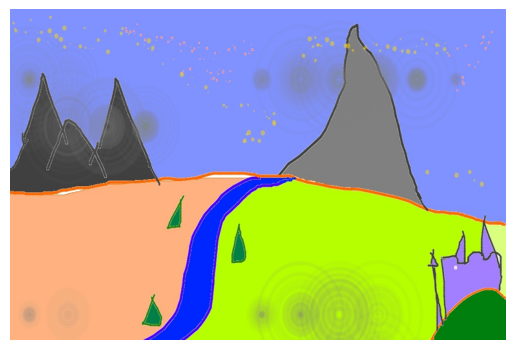

In [5]:
plt.imshow(init_image)
plt.axis('off')
plt.show()

In [6]:
pipe

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Useful website: https://huggingface.co/blog/stable_diffusion

Inside the pipeline there's a VAE and a Unet.

Things to do:
- Find a dataset of amateur pics and retrieve their embeds
- Find a dataset of pro pics and retrieve their embeds
- In theory, the prompt shouldn't affect this part if I use the embeddings produced by VAE's encoder, because that prompt will influence the Unet later
- Check if there is an appreciable difference between the embeddings of the two datasets:
    - either by performing a PCA and ideally find a PC that corresponds to an esthetic quality
    - or by classifying the embeddings: if a classifier is able to learn the distinction then there's a distinction and that's also enough for our purposes

Here below I find the embedding produced by the VAE's encoder. Maybe I need to use the Unet embedding?

In [21]:
import torchvision.transforms as transforms
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img import retrieve_latents

transform = transforms.ToTensor()
tensor_image = transform(init_image).to(device=device, dtype=torch.half).unsqueeze(0)

latents = retrieve_latents(pipe.vae.encode(tensor_image))

In [25]:
# shape (batch, latent_channels, width, height)

latents.shape

torch.Size([1, 4, 64, 96])

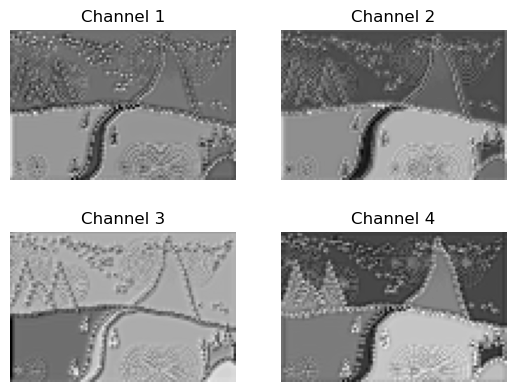

In [32]:
# Assuming latents is a tensor with shape (batch, latent_channels, width, height)
fig, axs = plt.subplots(2, 2)

# Plotting the four channels separately
for i, ax in enumerate(axs.flat):
    ax.imshow(latents[0, i].cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Channel {i+1}')

plt.show()

It seems that this is just a compressed version of the input, probably I need the unet embedding